In [6]:
import os
import sys
import numpy as np
import pandas as pd
import sklearn
import time
import redis
from catboost import CatBoostClassifier
if (os.getcwd().endswith("notebooks")):
    os.chdir("..")
sys.path.insert(0, os.path.abspath("tests/benchmark_scripts"))
print(os.getcwd())
import music_utils
from music_utils import get_features_from_redis

/content/Willump-Simple-master


In [ ]:
!pip install redis
!pip install catboost

     |████████████████████████████████| 119 kB 42.0 MB/s 
     |████████████████████████████████| 76.3 MB 1.3 MB/s 


In [7]:
db = redis.StrictRedis(host='10.213.180.163')
train_X, test_X, train_y, test_y = music_utils.load_music_dataset(db)


# host='172.17.0.2'

In [8]:
def music_train(y, X_list):
    X = pd.concat(X_list, axis=1)
    X = X[[f for f in music_utils.FEATURES if f in X.columns]]
    model = CatBoostClassifier(
        iterations=5,
        learning_rate=0.5,
        # num_leaves=(2 ** 8),
        depth=15,
        eval_metric="AUC")
    model = model.fit(X, y)
    return model

def music_predict(model, X_list):
    X = pd.concat(X_list, axis=1)
    X = X[[f for f in music_utils.FEATURES if f in X.columns]]
    if len(X) == 0:
        return np.zeros(0, dtype=np.float32)
    else:
        return model.predict(X)


def music_confidence(model, X_list):
    X = pd.concat(X_list, axis=1)
    X = X[[f for f in music_utils.FEATURES if f in X.columns]]
    return model.predict_proba(X)[:, 1]


def music_score(true_y, pred_y):
    fpr, tpr, _ = sklearn.metrics.roc_curve(true_y, pred_y, pos_label=1)
    return sklearn.metrics.auc(fpr, tpr)

In [17]:
os.chdir("willump")

In [18]:
from willump.evaluation.willump_executor import willump_execute

train_cascades_params = {} # The computed parameters will be stored here.

@willump_execute(train_function=music_train,
                 predict_function=music_predict,
                 confidence_function=music_confidence,
                 score_function=music_score,
                 train_cascades_params=train_cascades_params)
def music_train_pipeline(input_X, input_y):
    user_latent_features = get_features_from_redis(
        input_X, column="msno", name="features_uf", db=db)
    song_latent_features = get_features_from_redis(
        input_X, column="song_id", name="features_sf", db=db)
    user_cluster_features = get_features_from_redis(
        input_X, column="cluster_msno_25", name="uc_features", db=db)
    song_cluster_features = get_features_from_redis(
        input_X, column="cluster_song_id_25", name="sc_features", db=db)
    artist_cluster_features = get_features_from_redis(
        input_X, column="cluster_artist_name_25", name="ac_features", db=db)
    user_features = get_features_from_redis(
        input_X, column="msno", name="us_features", db=db)
    song_features = get_features_from_redis(
        input_X, column="song_id", name="ss_features", db=db)
    artist_features = get_features_from_redis(
        input_X, column="artist_name", name="as_features", db=db)
    genre_features = get_features_from_redis(
        input_X, column="genre_max", name="gs_features", db=db)
    city_features = get_features_from_redis(
        input_X, column="city", name="cs_features", db=db)
    ages_features = get_features_from_redis(
        input_X, column="bd", name="ages_features", db=db)
    language_features = get_features_from_redis(
        input_X, column="language", name="ls_features", db=db)
    gender_features = get_features_from_redis(
        input_X, column="gender", name="gender_features", db=db)
    composer_features = get_features_from_redis(
        input_X, column="composer", name="composer_features", db=db)
    lyrs_features = get_features_from_redis(
        input_X, column="lyricist", name="lyrs_features", db=db)
    sns_features = get_features_from_redis(
        input_X, column="source_screen_name", name="sns_features", db=db)
    stabs_features = get_features_from_redis(
        input_X, column="source_system_tab", name="stabs_features", db=db)
    stypes_features = get_features_from_redis(
        input_X, column="source_type", name="stypes_features", db=db)
    regs_features = get_features_from_redis(
        input_X, column="registered_via", name="regs_features", db=db)
    return music_train(input_y,
                       [user_latent_features, song_latent_features, user_cluster_features,
                        song_cluster_features, artist_cluster_features, user_features,
                        song_features, artist_features, genre_features, city_features,
                        ages_features, language_features, gender_features,
                        composer_features,lyrs_features, sns_features, stabs_features,
                        stypes_features, regs_features])

In [19]:
from willump.evaluation import cascades_construct

train_X_features, feature_costs, feature_names = music_utils.compute_features(train_X, db)

In [20]:
cascades_train_X, cascades_valid_X, cascades_train_y, cascades_valid_y = \
    cascades_construct.train_test_split(train_X_features, train_y, test_size=0.25, random_state=42)
train_set_full_model = music_train(cascades_train_y, cascades_train_X)

feature_importances = \
    cascades_construct.calculate_feature_importances(train_set_full_model,
                                                     cascades_valid_X, cascades_valid_y,
                                                     music_predict, music_score,
                                                     feature_names)

cascades_construct.pretty_print(feature_importances, feature_costs)

0:	total: 4.17s	remaining: 16.7s
1:	total: 8.45s	remaining: 12.7s
2:	total: 12.7s	remaining: 8.5s
3:	total: 16.9s	remaining: 4.22s
4:	total: 20.9s	remaining: 0us
Feature: user_latent_features      Cost:  1.000 Importance:  0.109
Feature: stabs_features            Cost:  1.000 Importance:  0.068
Feature: user_cluster_features     Cost:  1.000 Importance:  0.061
Feature: song_cluster_features     Cost:  1.000 Importance:  0.048
Feature: stypes_features           Cost:  1.000 Importance:  0.048
Feature: user_features             Cost:  1.000 Importance:  0.046
Feature: ages_features             Cost:  1.000 Importance:  0.034
Feature: artist_cluster_features   Cost:  1.000 Importance:  0.018
Feature: sns_features              Cost:  1.000 Importance:  0.017
Feature: regs_features             Cost:  1.000 Importance:  0.013
Feature: genre_features            Cost:  1.000 Importance:  0.012
Feature: gender_features           Cost:  1.000 Importance:  0.010
Feature: song_latent_features     

In [21]:
total_feature_cost = sum(feature_costs.values())
cost_cutoff = 0.5 * total_feature_cost
selected_indices = cascades_construct.select_features(feature_costs, feature_importances, cost_cutoff)
selected_features = [feature_names[i] for i in selected_indices]

print("Total feature cost: %5.3f  Selected feature cost cutoff: %5.3f" % (total_feature_cost, cost_cutoff))
print("Selected features:")
for feature in selected_features:
    print("\t%s" % feature)

Total feature cost: 19.000  Selected feature cost cutoff: 9.500
Selected features:
	user_latent_features
	user_cluster_features
	song_cluster_features
	artist_cluster_features
	user_features
	ages_features
	sns_features
	stabs_features
	stypes_features


In [22]:
threshold, fraction_approximated = \
    cascades_construct.calculate_feature_set_performance(cascades_train_X, cascades_train_y, 
                                                         cascades_valid_X, cascades_valid_y,
                                                         selected_indices,
                                                         music_train, music_predict,
                                                         music_confidence, music_score,
                                                         train_set_full_model)
selected_feature_cost = sum(feature_costs[feature_names[i]] for i in selected_indices)
expected_cost = fraction_approximated * selected_feature_cost + \
    (1 - fraction_approximated) * total_feature_cost

print("Confidence threshold: %5.3f  Percentage of inputs approximated: %5.3f" 
      % (threshold, fraction_approximated))
print("Expected Query Cost = Percent Approximated * Selected Feature Cost +\n" +
      "\t\t      Percent Not Approximated * Total Feature Cost")
print("\t\t    = %5.3f * %5.3f + %5.3f * %5.3f = %5.3f" % 
      (fraction_approximated, selected_feature_cost,
       1 - fraction_approximated, total_feature_cost, expected_cost))
print("Projected speedup: %5.3f" % (total_feature_cost / expected_cost))

0:	total: 2.39s	remaining: 9.55s
1:	total: 4.81s	remaining: 7.22s
2:	total: 7.15s	remaining: 4.77s
3:	total: 9.54s	remaining: 2.38s
4:	total: 11.9s	remaining: 0us
Confidence threshold: 0.600  Percentage of inputs approximated: 0.771
Expected Query Cost = Percent Approximated * Selected Feature Cost +
		      Percent Not Approximated * Total Feature Cost
		    = 0.771 * 9.000 + 0.229 * 19.000 = 11.290
Projected speedup: 1.683


In [23]:
total_feature_cost = sum(feature_costs.values())
cost_cutoff = 0.25 * total_feature_cost
selected_indices = cascades_construct.select_features(feature_costs, feature_importances, cost_cutoff)
selected_features = [feature_names[i] for i in selected_indices]

print("Total feature cost: %5.3f  Selected feature cost cutoff: %5.3f" % (total_feature_cost, cost_cutoff))
print("Selected features:")
for feature in selected_features:
    print("\t%s" % feature)

threshold, fraction_approximated = \
    cascades_construct.calculate_feature_set_performance(cascades_train_X, cascades_train_y, 
                                                         cascades_valid_X, cascades_valid_y,
                                                         selected_indices,
                                                         music_train, music_predict,
                                                         music_confidence, music_score,
                                                         train_set_full_model)
selected_feature_cost = sum(feature_costs[feature_names[i]] for i in selected_indices)
expected_cost = fraction_approximated * selected_feature_cost + \
(1 - fraction_approximated) * total_feature_cost
print("Confidence threshold: %5.3f  Percentage of inputs approximated: %5.3f" 
      % (threshold, fraction_approximated))
print("Expected Query Cost = Percent Approximated * Selected Feature Cost +\n" +
      "\t\t      Percent Not Approximated * Total Feature Cost")
print("\t\t    = %5.3f * %5.3f + %5.3f * %5.3f = %5.3f" % 
      (fraction_approximated, selected_feature_cost,
       1 - fraction_approximated, total_feature_cost, expected_cost))
print("Projected speedup: %5.3f" % (total_feature_cost / expected_cost))

Total feature cost: 19.000  Selected feature cost cutoff: 4.750
Selected features:
	user_latent_features
	user_cluster_features
	song_cluster_features
	stabs_features
0:	total: 2.21s	remaining: 8.84s
1:	total: 4.68s	remaining: 7.02s
2:	total: 6.91s	remaining: 4.61s
3:	total: 9.14s	remaining: 2.28s
4:	total: 11.4s	remaining: 0us
Confidence threshold: 0.600  Percentage of inputs approximated: 0.746
Expected Query Cost = Percent Approximated * Selected Feature Cost +
		      Percent Not Approximated * Total Feature Cost
		    = 0.746 * 4.000 + 0.254 * 19.000 = 7.807
Projected speedup: 2.434


In [25]:
cascades_params = {}
cascades_params["selected_feature_indices"] = selected_indices
cascades_params["cascade_threshold"] = threshold
full_model = music_train(train_y, train_X_features)
cascades_params["full_model"] = full_model
approximate_model = music_train(train_y, [train_X_features[i] for i in selected_indices])
cascades_params["approximate_model"] = approximate_model

0:	total: 4.47s	remaining: 17.9s
1:	total: 8.7s	remaining: 13s
2:	total: 13.1s	remaining: 8.74s
3:	total: 18.2s	remaining: 4.55s
4:	total: 22.6s	remaining: 0us
0:	total: 2.29s	remaining: 9.15s
1:	total: 4.57s	remaining: 6.86s
2:	total: 6.94s	remaining: 4.62s
3:	total: 9.29s	remaining: 2.32s
4:	total: 11.7s	remaining: 0us


In [26]:
def music_eval_pipeline(input_X, model):
    user_latent_features = get_features_from_redis(
        input_X, column="msno", name="features_uf", db=db)
    song_latent_features = get_features_from_redis(
        input_X, column="song_id", name="features_sf", db=db)
    user_cluster_features = get_features_from_redis(
        input_X, column="cluster_msno_25", name="uc_features", db=db)
    song_cluster_features = get_features_from_redis(
        input_X, column="cluster_song_id_25", name="sc_features", db=db)
    artist_cluster_features = get_features_from_redis(
        input_X, column="cluster_artist_name_25", name="ac_features", db=db)
    user_features = get_features_from_redis(
        input_X, column="msno", name="us_features", db=db)
    song_features = get_features_from_redis(
        input_X, column="song_id", name="ss_features", db=db)
    artist_features = get_features_from_redis(
        input_X, column="artist_name", name="as_features", db=db)
    genre_features = get_features_from_redis(
        input_X, column="genre_max", name="gs_features", db=db)
    city_features = get_features_from_redis(
        input_X, column="city", name="cs_features", db=db)
    ages_features = get_features_from_redis(
        input_X, column="bd", name="ages_features", db=db)
    language_features = get_features_from_redis(
        input_X, column="language", name="ls_features", db=db)
    gender_features = get_features_from_redis(
        input_X, column="gender", name="gender_features", db=db)
    composer_features = get_features_from_redis(
        input_X, column="composer", name="composer_features", db=db)
    lyrs_features = get_features_from_redis(
        input_X, column="lyricist", name="lyrs_features", db=db)
    sns_features = get_features_from_redis(
        input_X, column="source_screen_name", name="sns_features", db=db)
    stabs_features = get_features_from_redis(
        input_X, column="source_system_tab", name="stabs_features", db=db)
    stypes_features = get_features_from_redis(
        input_X, column="source_type", name="stypes_features", db=db)
    regs_features = get_features_from_redis(
        input_X, column="registered_via", name="regs_features", db=db)
    return music_predict(model,
                       [user_latent_features, song_latent_features, user_cluster_features,
                        song_cluster_features, artist_cluster_features, user_features,
                        song_features, artist_features, genre_features, city_features,
                        ages_features, language_features, gender_features,
                        composer_features,lyrs_features, sns_features, stabs_features,
                        stypes_features, regs_features])

time_start = time.time()
preds = music_eval_pipeline(test_X[:2000], full_model)
unopt_time_elapsed = time.time() - time_start
print("Elapsed Time %fs" % unopt_time_elapsed)

print("AUC Score: %f" % music_score(preds, test_y[:2000]))

Elapsed Time 15.486808s
AUC Score: 0.713580


In [27]:
@willump_execute(predict_function=music_predict,
                 confidence_function=music_confidence,
                 predict_cascades_params=cascades_params)
def music_eval_pipeline(input_X, model):
    user_latent_features = get_features_from_redis(
        input_X, column="msno", name="features_uf", db=db)
    song_latent_features = get_features_from_redis(
        input_X, column="song_id", name="features_sf", db=db)
    user_cluster_features = get_features_from_redis(
        input_X, column="cluster_msno_25", name="uc_features", db=db)
    song_cluster_features = get_features_from_redis(
        input_X, column="cluster_song_id_25", name="sc_features", db=db)
    artist_cluster_features = get_features_from_redis(
        input_X, column="cluster_artist_name_25", name="ac_features", db=db)
    user_features = get_features_from_redis(
        input_X, column="msno", name="us_features", db=db)
    song_features = get_features_from_redis(
        input_X, column="song_id", name="ss_features", db=db)
    artist_features = get_features_from_redis(
        input_X, column="artist_name", name="as_features", db=db)
    genre_features = get_features_from_redis(
        input_X, column="genre_max", name="gs_features", db=db)
    city_features = get_features_from_redis(
        input_X, column="city", name="cs_features", db=db)
    ages_features = get_features_from_redis(
        input_X, column="bd", name="ages_features", db=db)
    language_features = get_features_from_redis(
        input_X, column="language", name="ls_features", db=db)
    gender_features = get_features_from_redis(
        input_X, column="gender", name="gender_features", db=db)
    composer_features = get_features_from_redis(
        input_X, column="composer", name="composer_features", db=db)
    lyrs_features = get_features_from_redis(
        input_X, column="lyricist", name="lyrs_features", db=db)
    sns_features = get_features_from_redis(
        input_X, column="source_screen_name", name="sns_features", db=db)
    stabs_features = get_features_from_redis(
        input_X, column="source_system_tab", name="stabs_features", db=db)
    stypes_features = get_features_from_redis(
        input_X, column="source_type", name="stypes_features", db=db)
    regs_features = get_features_from_redis(
        input_X, column="registered_via", name="regs_features", db=db)
    return music_predict(model,
                       [user_latent_features, song_latent_features, user_cluster_features,
                        song_cluster_features, artist_cluster_features, user_features,
                        song_features, artist_features, genre_features, city_features,
                        ages_features, language_features, gender_features,
                        composer_features,lyrs_features, sns_features, stabs_features,
                        stypes_features, regs_features])

music_eval_pipeline(test_X.iloc[:100], full_model)
music_eval_pipeline(test_X.iloc[:100], full_model)
time_start = time.time()
preds = music_eval_pipeline(test_X[:2000], full_model)
cascades_time_elapsed = time.time() - time_start
print("Elapsed Time %fs" % cascades_time_elapsed)

print("AUC Score: %f" % music_score(preds, test_y[:2000]))

Elapsed Time 6.246383s
AUC Score: 0.733291


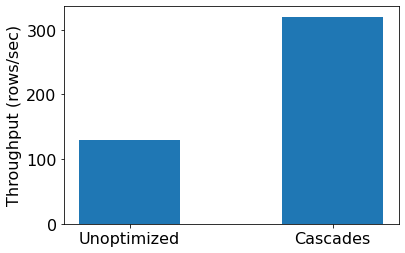

In [28]:
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
fig, axes = plt.subplots(figsize=(6, 4), ncols=1, nrows=1,
                         sharex=False, sharey=False)
x = np.arange(2)
width = 0.5  # the width of the bars

bars = axes.bar(x, [2000 / unopt_time_elapsed, 2000 / cascades_time_elapsed], width)
axes.set(xlabel='', ylabel='Throughput (rows/sec)')
axes.set_xticks(x)
axes.set_xticklabels(["Unoptimized", "Cascades"])
plt.show()

# Clearly, using cascades isn't helping with catboost as classifier

In all cases, AUC is decreasing -> not a good sign
Elapsed time is deceresing but minutely.

All these changes are incremental

1. Keeping params as is --> 
    No improvement w and w/o Willump

2. Increasing iterations from 1 to 5 --> 
    vv minute improvement w and w/o Willump. Elapsed time remains same, AUC score decreases from 14.78 to 14.62.

3. Increasing learning rate from 0.1 to 0.5 -->
    Elapsed Time decreases from 14.890806s to 14.790561s
    AUC Score decreases from 0.713580 to 0.652102
